In [ ]:
!pip install tensorflow-io

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 28.0/28.0 MB 14.4 MB/s eta 0:00:00


In [ ]:
import tensorflow as tf
import tensorflow_io as tfio
from matplotlib import pyplot as plt
import os

In [ ]:
from google.colab import drive
drive.mount('/content/gdrive', force_remount=True)

Mounted at /content/gdrive


### Build Data Loading Functions

### 1. Defining paths to data

In [ ]:
Capuchin_file = '/content/gdrive/MyDrive/Deep Audio Classifier/dataset/Parsed_Capuchinbird_Clips/XC114131-0.wav'
Not_Capuchin_file = '/content/gdrive/MyDrive/Deep Audio Classifier/dataset/Parsed_Not_Capuchinbird_Clips/Crickets-chirping-0.wav'

In [ ]:
Capuchin_file

'/content/gdrive/MyDrive/Deep Audio Classifier/dataset/Parsed_Capuchinbird_Clips/XC114131-0.wav'

In [ ]:
Not_Capuchin_file

'/content/gdrive/MyDrive/Deep Audio Classifier/dataset/Parsed_Not_Capuchinbird_Clips/Crickets-chirping-0.wav'

### 2. Build Dataloading function

In [ ]:
#Processing audio file to 16 hertz and it will have mono channel
def load_wave_16k_mono(filename):
    # Load encoded wave file
    file_content = tf.io.read_file(filename)
    #Decode the wave (tensors by channels)
    wav, sample_rate = tf.audio.decode_wav(file_content, desired_channels=1)
    #Remove trailing axis
    wav = tf.squeeze(wav, axis=1)
    sample_rate = tf.cast(sample_rate, dtype=tf.int64)
    #Sample rate goes from 48000Hz to 16000Hz - amplitude of the audio wave
    wav = tfio.audio.resample(wav, rate_in = sample_rate, rate_out = 16000)
    return wav

### 3. Plot the waves

In [ ]:
wave = load_wave_16k_mono(Capuchin_file)
nwave = load_wave_16k_mono(Not_Capuchin_file)

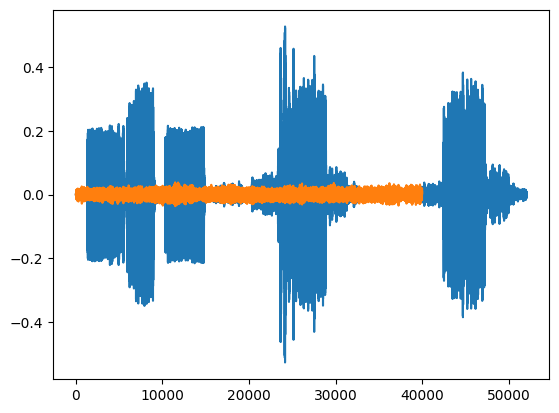

In [ ]:
plt.plot(nwave)
plt.plot(wave)
plt.show()

### 3. Create a Tensorflow Dataset

### 3.1 Define paths

In [ ]:
POS = os.path.join('/content/gdrive/MyDrive/Deep Audio Classifier/dataset/','Parsed_Capuchinbird_Clips')
NEG = os.path.join('/content/gdrive/MyDrive/Deep Audio Classifier/dataset/','Parsed_Not_Capuchinbird_Clips')

### 3.2 Create Tensorflow Dataset

In [ ]:
pos = tf.data.Dataset.list_files(POS+'/*.wav')
neg = tf.data.Dataset.list_files(NEG+'/*.wav')

In [ ]:
pos.as_numpy_iterator().next()

b'/content/gdrive/MyDrive/Deep Audio Classifier/dataset/Parsed_Capuchinbird_Clips/XC216010-4.wav'

In [ ]:
len(neg), len(pos)

(593, 217)

In [ ]:
positives = tf.data.Dataset.zip((pos, tf.data.Dataset.from_tensor_slices(tf.ones(len(pos)))))
negatives = tf.data.Dataset.zip((neg, tf.data.Dataset.from_tensor_slices(tf.zeros(len(neg)))))
data = positives.concatenate(negatives)

In [ ]:
positives.as_numpy_iterator().next()

(b'/content/gdrive/MyDrive/Deep Audio Classifier/dataset/Parsed_Capuchinbird_Clips/XC65196-3.wav',
 1.0)

In [ ]:
negatives.as_numpy_iterator().next()

(b'/content/gdrive/MyDrive/Deep Audio Classifier/dataset/Parsed_Not_Capuchinbird_Clips/screech-owl-sounds-at-night-6.wav',
 0.0)

In [ ]:
data.shuffle(1000).as_numpy_iterator().next()

(b'/content/gdrive/MyDrive/Deep Audio Classifier/dataset/Parsed_Not_Capuchinbird_Clips/rain-thunder-and-crickets-sound-effect-12.wav',
 0.0)

### 4. Average length of Capuchin bird call

### 4.1 Calculate wave cycle length

In [ ]:
lengths = []
for file in os.listdir(os.path.join('/content/gdrive/MyDrive/Deep Audio Classifier/dataset/','Parsed_Capuchinbird_Clips')):
  tensor_wav = load_wave_16k_mono(os.path.join('/content/gdrive/MyDrive/Deep Audio Classifier/dataset/','Parsed_Capuchinbird_Clips',file))
  lengths.append(len(tensor_wav))

In [ ]:
lengths

### 4.2 Summary state

In [ ]:
tf.math.reduce_mean(lengths)

<tf.Tensor: shape=(), dtype=int32, numpy=54156>

In [ ]:
import numpy as np
int(np.mean(lengths))

54156

In [ ]:
np.median(lengths)

56000.0

In [ ]:
np.min(lengths)

32000

In [ ]:
np.max(lengths)

80000

### 5. Build Preprocessing function to convert to Spectrogram:



### 5.1 Build Preprocessing Function

In [ ]:
def preprocess(filename, label):
  wav = load_wave_16k_mono(filename)
  wav = wav[:48000]
  zero_padding = tf.zeros([48000] - tf.shape(wav), dtype = tf.float32)
  wav = tf.concat([zero_padding, wav], axis=0)
  spectrogram = tf.signal.stft(wav, frame_length=320, frame_step=32)
  spectrogram = tf.abs(spectrogram)
  spectrogram = tf.expand_dims(spectrogram, axis=2)
  return spectrogram, label

In [ ]:
wav = load_wave_16k_mono(Capuchin_file)
wav

<tf.Tensor: shape=(40000,), dtype=float32, numpy=
array([-2.1452930e-08,  2.9903514e-08,  2.3691292e-08, ...,
        1.1810826e-02,  1.3428938e-02,  3.8246573e-03], dtype=float32)>

In [ ]:
wav = wav[:48000]
wav

<tf.Tensor: shape=(40000,), dtype=float32, numpy=
array([-2.1452930e-08,  2.9903514e-08,  2.3691292e-08, ...,
        1.1810826e-02,  1.3428938e-02,  3.8246573e-03], dtype=float32)>

In [ ]:
zero_padding = tf.zeros([48000] - tf.shape(wav), dtype = tf.float32)
wav = tf.concat([zero_padding, wav], axis=0)
wav

<tf.Tensor: shape=(48000,), dtype=float32, numpy=
array([0.        , 0.        , 0.        , ..., 0.01181083, 0.01342894,
       0.00382466], dtype=float32)>

In [ ]:
spectrogram = tf.signal.stft(wav, frame_length=320, frame_step=32)
spectrogram = tf.abs(spectrogram)
spectrogram = tf.expand_dims(spectrogram, axis=2)
spectrogram

### 5.2 Test out the function and Visualize the spectrogram

In [ ]:
filepath, label = positives.shuffle(10000).as_numpy_iterator().next()

In [ ]:
spectrogram, label = preprocess(filepath, label)

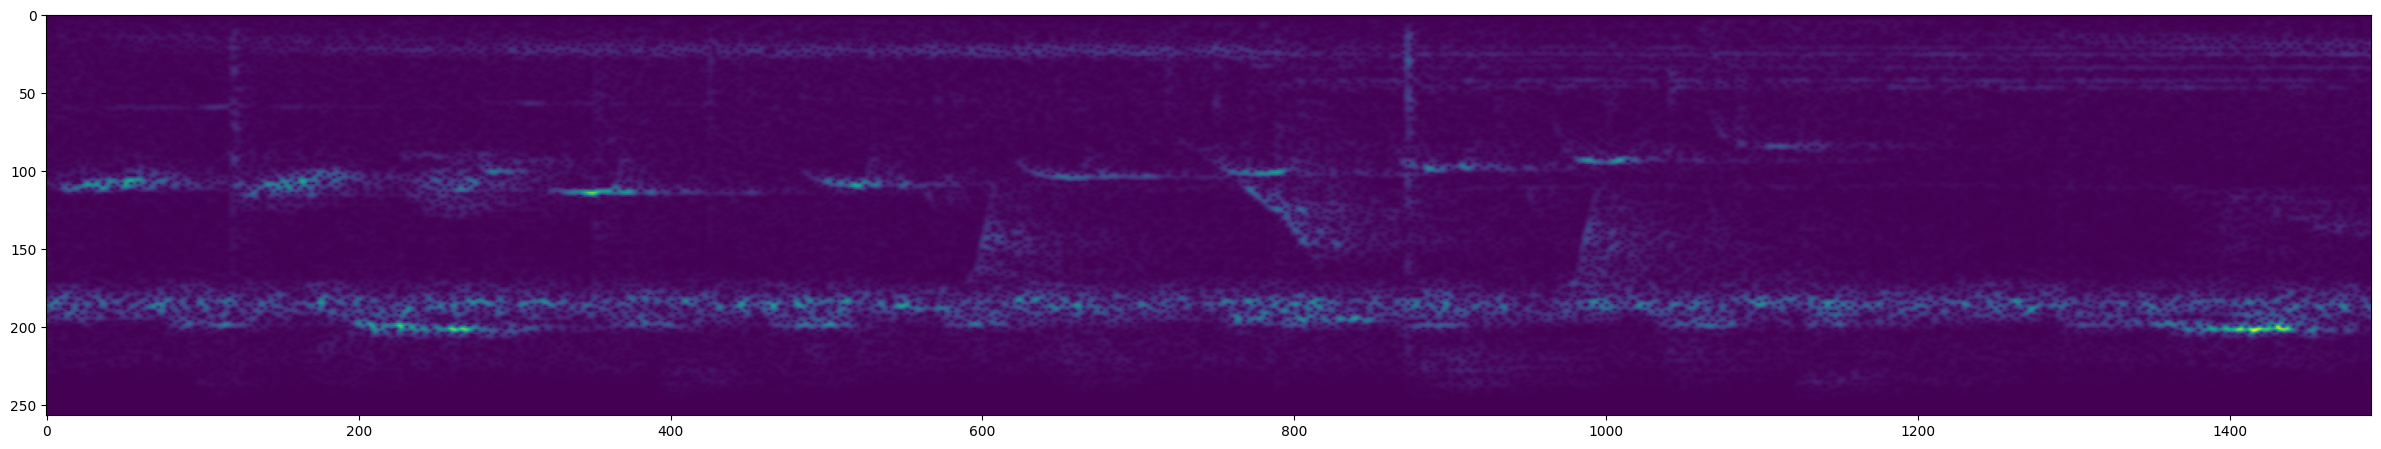

In [ ]:
plt.figure(figsize=(30,20))
plt.imshow(tf.transpose(spectrogram)[0])
plt.show()

In [ ]:
filepath, label = negatives.shuffle(10000).as_numpy_iterator().next()

In [ ]:
spectrogram, label = preprocess(filepath, label)

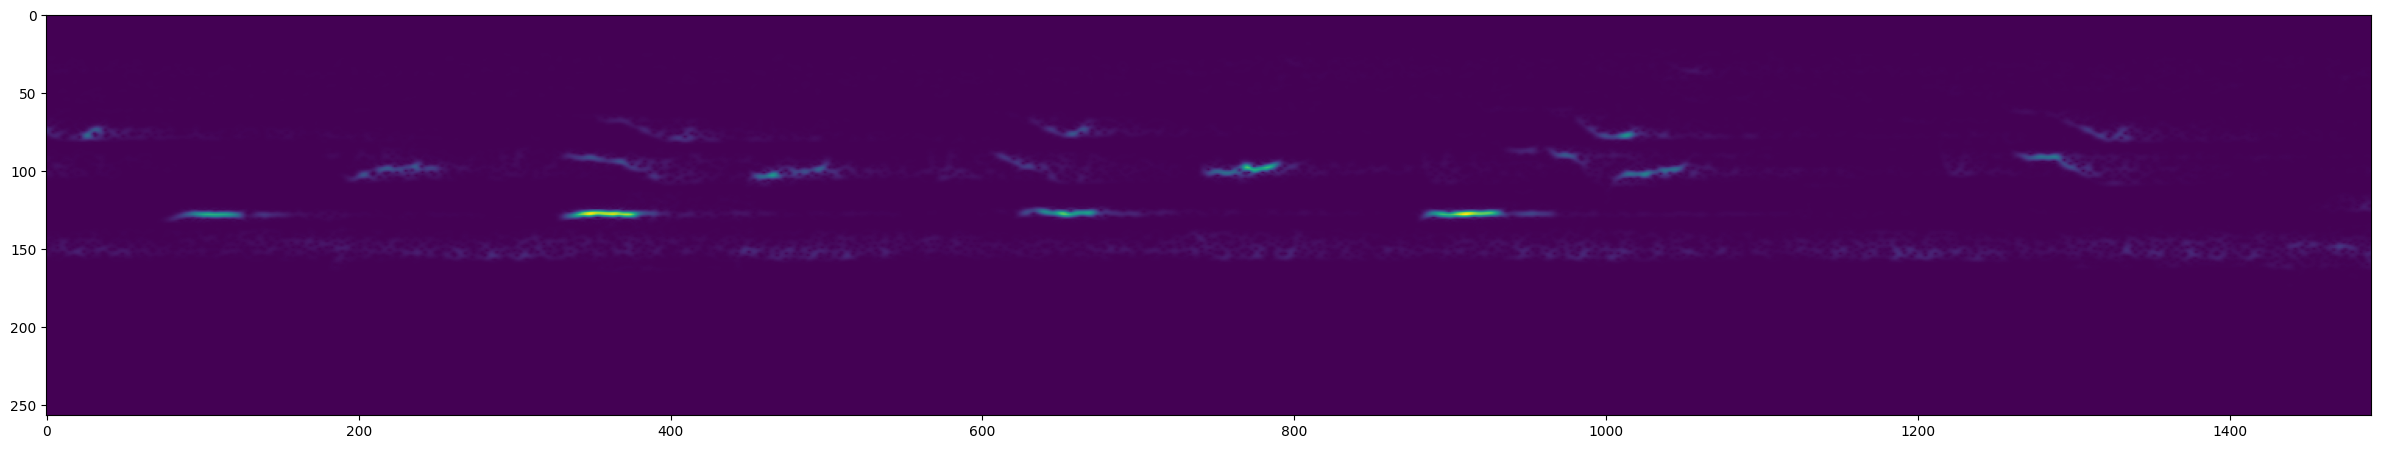

In [ ]:
plt.figure(figsize=(30,20))
plt.imshow(tf.transpose(spectrogram)[0])
plt.show()

### 6. Creating training and testing partitions

### 6.1 Create a tensorflow pipeline

In [ ]:
data = data.map(preprocess)
data = data.cache()
data = data.shuffle(buffer_size = 1000)
data = data.batch(16)
data = data.prefetch(8)

### 6.2 Split into training and testing

In [ ]:
len(data)*.3

15.299999999999999

In [ ]:
train = data.take(36)
test = data.skip(36).take(15)

In [ ]:
test.as_numpy_iterator().next()[1]

AttributeError: ignored

### 6.3 Test One batch

In [ ]:
sample, labels = train.as_numpy_iterator().next()

In [ ]:
sample.shape

(16, 1491, 257, 1)

In [ ]:
labels.shape

(16,)

In [ ]:
labels

array([1., 0., 0., 1., 0., 0., 0., 0., 0., 0., 1., 0., 1., 0., 0., 1.],
      dtype=float32)

### 7. Build Deep Learning Model

### 7.1 Load Tensorflow Dependencies

In [ ]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D, Dense, Flatten, MaxPooling2D

### 7.2 Build Sequential Model, Compile and View Summary

In [ ]:
model = Sequential()
model.add(Conv2D(8, (3,3), activation = 'relu', input_shape = (1491, 257, 1)))
model.add(Conv2D(8, (3,3), activation='relu'))
model.add(Flatten())
model.add(Dense(64, activation='relu'))
model.add(Dense(1, activation='sigmoid'))

In [ ]:
model.compile(optimizer='Adam', loss='BinaryCrossentropy', metrics = [tf.keras.metrics.Recall(), tf.keras.metrics.Precision(), tf.keras.metrics.Accuracy()])

In [ ]:
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 1489, 255, 8)      80        
                                                                 
 conv2d_1 (Conv2D)           (None, 1487, 253, 8)      584       
                                                                 
 flatten (Flatten)           (None, 3009688)           0         
                                                                 
 dense (Dense)               (None, 64)                192620096 
                                                                 
 dense_1 (Dense)             (None, 1)                 65        
                                                                 
Total params: 192,620,825
Trainable params: 192,620,825
Non-trainable params: 0
_________________________________________________________________


### Fit Model, View Loss and KPI Plots

In [ ]:
hist = model.fit(train, epochs=4, validation_data=test, batch_size=4)

Epoch 1/4
36/36 [==============================] - 322s 9s/step - loss: 0.0562 - recall_1: 0.9810 - precision_1: 0.9810 - accuracy: 0.3507 - val_loss: 0.1149 - val_recall_1: 1.0000 - val_precision_1: 0.8667 - val_accuracy: 0.3803
Epoch 2/4
36/36 [==============================] - 306s 9s/step - loss: 0.1774 - recall_1: 0.9810 - precision_1: 0.9627 - accuracy: 0.5590 - val_loss: 0.0015 - val_recall_1: 1.0000 - val_precision_1: 1.0000 - val_accuracy: 0.4573
Epoch 3/4
36/36 [==============================] - 322s 9s/step - loss: 0.0405 - recall_1: 0.9938 - precision_1: 0.9877 - accuracy: 0.4271 - val_loss: 4.9569e-05 - val_recall_1: 1.0000 - val_precision_1: 1.0000 - val_accuracy: 0.3932
Epoch 4/4
36/36 [==============================] - 321s 9s/step - loss: 0.0079 - recall_1: 0.9932 - precision_1: 0.9932 - accuracy: 0.4080 - val_loss: 8.7513e-05 - val_recall_1: 1.0000 - val_precision_1: 1.0000 - val_accuracy: 0.4701


In [ ]:
hist.history

{'loss': [1.7754337787628174,
  0.08492358773946762,
  0.038602374494075775,
  0.017511876299977303],
 'recall': [0.8986486196517944, 0.9867549538612366, 1.0, 1.0],
 'precision': [0.8060606122016907,
  0.9802631735801697,
  0.9939758777618408,
  1.0],
 'val_loss': [0.16104525327682495,
  0.06536033004522324,
  0.026025494560599327,
  0.004692086484283209],
 'val_recall': [0.8615384697914124, 1.0, 1.0, 1.0],
 'val_precision': [0.9824561476707458, 0.9838709831237793, 1.0, 1.0]}

In [ ]:
train_accuracy = hist.history['accuracy']
validation_accuracy = hist.history['val_accuracy']

KeyError: ignored

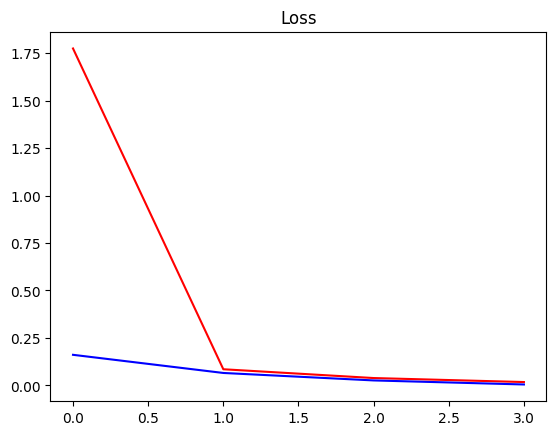

In [ ]:
plt.title('Loss')
plt.plot(hist.history['loss'], 'r')
plt.plot(hist.history['val_loss'],'b')
plt.show()

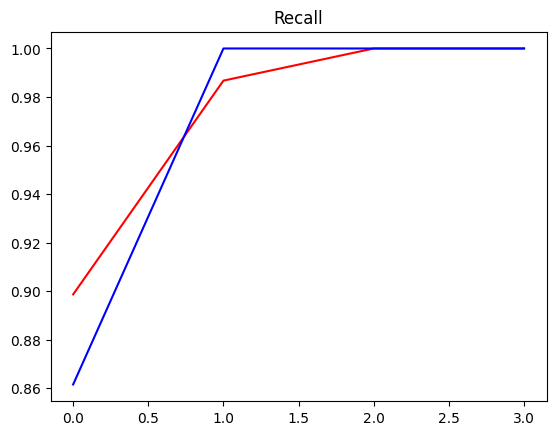

In [ ]:
plt.title('Recall')
plt.plot(hist.history['recall'], 'r')
plt.plot(hist.history['val_recall'],'b')
plt.show()

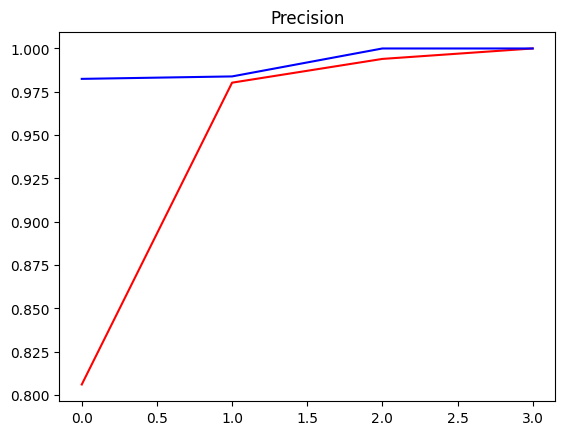

In [ ]:
plt.title('Precision')
plt.plot(hist.history['precision'], 'r')
plt.plot(hist.history['val_precision'],'b')
plt.show()

### 8. Make a prediction on single clip

In [ ]:
X_test, y_test = test.as_numpy_iterator().next()

In [ ]:
yhat = model.predict(X_test)

1/1 [==============================] - 3s 3s/step


In [ ]:
yhat = [1 if prediction > 0.5 else 0 for prediction in yhat]

In [ ]:
yhat

[0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 1, 0, 1, 0, 1, 0]

In [ ]:
import numpy as np

In [ ]:
np.sum(yhat), np.sum(y_test)

(4, 4.0)

### 9. Build Forest Parsing Functions

### 9.1 Load up MP3

In [ ]:
def load_mp3_16k_mono(filename):
  res = tfio.audio.AudioIOTensor(filename)
  tensor = res.to_tensor()
  tensor = tf.math.reduce_sum(tensor, axis=1)/2
  #Extract sample_rate and cast
  sample_rate =res.rate
  sample_rate = tf.cast(sample_rate, dtype = tf.int64)
  #Resample to 16kHz
  wav = tfio.audio.resample(tensor, rate_in = sample_rate, rate_out = 16000)
  return wav

In [ ]:
mp3 = os.path.join('/content/gdrive/MyDrive/Deep Audio Classifier/dataset','Forest Recordings', 'recording_00.mp3')

In [ ]:
wav = load_mp3_16k_mono(mp3)

In [ ]:
audio_slices = tf.keras.utils.timeseries_dataset_from_array(wav, wav, sequence_length=48000 , sequence_stride=48000,batch_size= 1)

In [ ]:
len(audio_slices)

60

In [ ]:
sample, labels = audio_slices.as_numpy_iterator().next()

In [ ]:
sample

array([[ 8.1433272e-12, -5.7019250e-12, -5.3486417e-12, ...,
         6.2619494e-03, -1.5455363e-02, -8.7941047e-03]], dtype=float32)

In [ ]:
sample.shape

(1, 48000)

In [ ]:
labels.shape

(1,)

### 9.2 Convert clips to Spectrogram

In [ ]:
def preprocess_mp3(sample, index):
  sample = sample[0]
  zero_padding = tf.zeros([48000] - tf.shape(sample), dtype = tf.float32)
  wav = tf.concat([zero_padding, sample], axis=0)
  spectrogram = tf.signal.stft(wav, frame_length=320, frame_step=32)
  spectrogram = tf.abs(spectrogram)
  spectrogram = tf.expand_dims(spectrogram, axis=2)
  return spectrogram

### 9.3 Convert audio clips to windows and make predictions

In [ ]:
audio_slices = tf.keras.utils.timeseries_dataset_from_array(wav, wav, sequence_length=48000, sequence_stride=48000, batch_size=1)
audio_slices = audio_slices.map(preprocess_mp3)
audio_slices = audio_slices.batch(64)

In [ ]:
yhat = model.predict(audio_slices)
yhat = [1 if prediction > 0.99  else 0 for prediction in yhat]

1/1 [==============================] - 10s 10s/step


In [ ]:
len(yhat)

60

In [ ]:
yhat

[0,
 0,
 0,
 0,
 1,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 1,
 1,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 1,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 1,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 1,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0]

In [ ]:
calls = []
for i in yhat:
  if i==1:
    calls.append(1)

In [ ]:
len(calls)

6

### 9.4 Group consecutive calls together

In [ ]:
from itertools import groupby

In [ ]:
yhat = [key for key, group in groupby(yhat)]

In [ ]:
yhat

[0, 1, 0, 1, 0, 1, 0, 1, 0, 1, 0]

In [ ]:
np.sum(yhat)

5

### 10. Predictions for all files

In [ ]:
results = {}
for file in os.listdir(os.path.join('/content/gdrive/MyDrive/Deep Audio Classifier/dataset','Forest Recordings')):
  FILEPATH = os.path.join('/content/gdrive/MyDrive/Deep Audio Classifier/dataset','Forest Recordings',file)

  wav = load_mp3_16k_mono(FILEPATH)

  audio_slices = tf.keras.utils.timeseries_dataset_from_array(wav, wav, sequence_length=48000, sequence_stride=48000, batch_size=1)
  audio_slices = audio_slices.map(preprocess_mp3)
  audio_slices = audio_slices.batch(64)

  yhat = model.predict(audio_slices)

  results[file] = yhat

1/1 [==============================] - 11s 11s/step


In [ ]:
results.items()

### 10.1 Convert predictions to classes

In [ ]:
class_preds = {}
for file, logits in results.items():
    class_preds[file] = [1 if prediction > 0.99 else 0 for prediction in logits]
class_preds

{'recording_00.mp3': [0,
  0,
  0,
  0,
  1,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  1,
  1,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  1,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  1,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  1,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0],
 'recording_01.mp3': [0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0],
 'recording_02.mp3': [0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0],
 'recording_03.mp3': [0,
  0,
  0,
  

### 10.2 Group Consecutive Detections

In [ ]:
postprocessed = {}
for file, scores in class_preds.items():
    postprocessed[file] = tf.math.reduce_sum([key for key, group in groupby(scores)]).numpy()
postprocessed

{'recording_00.mp3': 5,
 'recording_01.mp3': 0,
 'recording_02.mp3': 0,
 'recording_03.mp3': 0,
 'recording_04.mp3': 4,
 'recording_05.mp3': 0,
 'recording_06.mp3': 5,
 'recording_07.mp3': 2,
 'recording_08.mp3': 25,
 'recording_09.mp3': 0,
 'recording_10.mp3': 5,
 'recording_11.mp3': 3,
 'recording_12.mp3': 0,
 'recording_13.mp3': 0,
 'recording_14.mp3': 0,
 'recording_15.mp3': 2,
 'recording_16.mp3': 3,
 'recording_17.mp3': 3,
 'recording_18.mp3': 2,
 'recording_19.mp3': 0,
 'recording_20.mp3': 0,
 'recording_21.mp3': 1,
 'recording_22.mp3': 2,
 'recording_23.mp3': 5,
 'recording_24.mp3': 0,
 'recording_25.mp3': 2,
 'recording_26.mp3': 2,
 'recording_27.mp3': 0,
 'recording_28.mp3': 4,
 'recording_29.mp3': 0,
 'recording_30.mp3': 3,
 'recording_31.mp3': 1,
 'recording_32.mp3': 2,
 'recording_33.mp3': 0,
 'recording_34.mp3': 4,
 'recording_35.mp3': 0,
 'recording_36.mp3': 0,
 'recording_37.mp3': 3,
 'recording_38.mp3': 1,
 'recording_39.mp3': 7,
 'recording_40.mp3': 1,
 'recording_41.

In [ ]:
test_loss, test_accuracy = model.evaluate(yhat, test_labels, batch_size=32)

### 11 Export Predictions

In [ ]:
import csv

In [ ]:
with open('/content/gdrive/MyDrive/Deep Audio Classifier/capuchin_bird_results.csv', 'w', newline='') as f:
    writer = csv.writer(f, delimiter=',')
    writer.writerow(['recording', 'capuchin_calls'])
    for key, value in postprocessed.items():
        writer.writerow([key, value])